In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

# 공개일, 제목, 조회수, 좋아요수, 싫어요수, 댓글수

In [125]:
publishedAt = []
title = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []

for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])
    likeCount.append(stats[i]['statistics']['likeCount'])
    dislikeCount.append(stats[i]['statistics']['dislikeCount'])
    commentCount.append(stats[i]['statistics']['commentCount'])

In [126]:
dict = {}
dict["publishedAt"] = publishedAt
dict["title"] = title
dict["viewCount"] = viewCount
dict['likeCount'] = likeCount
dict['dislikeCount'] = dislikeCount
dict['commentCount'] = commentCount

In [127]:
import pandas as pd
df = pd.DataFrame.from_dict(dict)

# int로 변환

In [128]:
df['viewCount'] = df['viewCount'].astype(int)
df['likeCount'] = df['likeCount'].astype(int)
df['dislikeCount'] = df['dislikeCount'].astype(int)
df['commentCount'] = df['commentCount'].astype(int)

# 좋아요/싫어요 비율

In [129]:
# 0으로 나누는 걸 방지하기 위해 0.001을 더했다.
df['likeRatio'] = df['likeCount'] / (df['likeCount'] + df['dislikeCount'] + 0.01)

# 제목에 '에이치엘비'가 없다면 Drop하기

In [130]:
df['에이치엘비'] = df['title'].str.contains('에이치엘비')
df = df.loc[(df['에이치엘비'] == True)]
len(df)

1451

# 제목에 '에이치엘비생명과학'이 있다면 Drop하기

In [131]:
df['에이치엘비생명과학'] = df['title'].str.contains('에이치엘비생명과학')
df = df.loc[df['에이치엘비생명과학'] == False]
len(df)

1414

# 제목에 '에이치엘비제약'이 있다면 Drop하기

In [132]:
df['에이치엘비제약'] = df['title'].str.contains('에이치엘비제약')
df = df.loc[(df['에이치엘비제약'] == False)]
len(df)

1386

# 과거 절반 데이터 Drop하기

In [133]:
df = df[:int(len(df)/2)]
len(df)

693

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [134]:
df = df[5:]
len(df)

688

# 분석하려는 것들만 남기고 Drop하기

In [135]:
df = df[['publishedAt','title','viewCount']]

In [136]:
df.head()

,publishedAt,title,viewCount
5,2021-04-08T21:00:31Z,에이치엘비 베리스모 CAR-T 중국 시장 진출 본격화하면 현재 긴밀한 관계를 맺고 ...,5411
6,2021-04-08T08:00:09Z,에이치엘비 CAR-T 상업화 최소 3년이상 앞당길 수 있다!! CAR-T세포가 활성...,7072
7,2021-04-08T01:34:11Z,에이치엘비 주주 오세훈 서울시장 당선!!,6202
8,2021-04-07T21:00:15Z,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8642
9,2021-04-07T08:15:01Z,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7713


# 일정을 나타내는 키워드
- 1월을 정규식으로 표현하면 [0-9]+[월] 
- 1일을 정규식으로 표현하면 [0-9]+[일] 
- 다음주,다음 주, 다음달, 다음 달, 이번주, 이번 주, 이번달, 이번 달  
- 내일  

| 메타 문자는 or과 동일한 의미로 사용된다. A|B라는 정규식이 있다면 A 또는 B라는 의미가 된다.  
참고 링크 : https://wikidocs.net/4309

In [137]:
import re
def reg_func(word):
    if re.compile('[0-9]+[월]|다음주|다음 주|다음달|다음 달|이번주|이번 주|이번달|이번 달|내일').search(word):
        return True
    else:
        return False

In [138]:
df_schedule = df.copy()

In [139]:
df_schedule['schedule'] = df_schedule['title'].apply(reg_func)

In [140]:
df_schedule.loc[(df_schedule['schedule'] == True)].head()

,publishedAt,title,viewCount,schedule
12,2021-04-06T12:14:22Z,에이치엘비 고통분담방송 2021년 4월 6일 화요일,6714,True
19,2021-04-04T21:00:02Z,"에이치엘비, 미국암학회(AACR)이 4월 10일부터 개최!! 참석하는 기업과 주목해...",13119,True
26,2021-04-02T11:41:28Z,"에이치엘비 5월3일 공매도 재개 전, 의문의 대차거래 500만주와 공매도잔고 100...",14266,True
30,2021-04-01T10:34:28Z,에이치엘비 실시간 라이브 방송 2021년 4월 1일,6117,True
66,2021-03-21T15:13:30Z,"에이치엘비, 4월 초 옵티머스 금감원 착오 취소 법리 적용하여 전액 배상 예상!",14063,True


# 라이브 영상 Drop하기

In [141]:
import re
def reg_live(word):
    if re.compile('라이브').search(word):
        return True
    else:
        return False

In [142]:
df_schedule['live'] = df_schedule['title'].apply(reg_live)

In [143]:
df_schedule.loc[(df_schedule['live'] == True)].head()

,publishedAt,title,viewCount,schedule,live
30,2021-04-01T10:34:28Z,에이치엘비 실시간 라이브 방송 2021년 4월 1일,6117,True,True
41,2021-03-29T11:00:50Z,에이치엘비 실시간 라이브 방송,8609,False,True
60,2021-03-23T11:10:32Z,에이치엘비 실시간 라이브 방송,7003,False,True
73,2021-03-19T11:02:34Z,에이치엘비 실시간 라이브 방송,7737,False,True
78,2021-03-18T08:21:26Z,에이치엘비 실시간 라이브 방송: 주가 원위치 회복!,8594,False,True


In [144]:
df_schedule = df_schedule.loc[(df_schedule['live'] == False)]

# 조회수 평균 구하기

In [145]:
df_schedule.head()

,publishedAt,title,viewCount,schedule,live
5,2021-04-08T21:00:31Z,에이치엘비 베리스모 CAR-T 중국 시장 진출 본격화하면 현재 긴밀한 관계를 맺고 ...,5411,False,False
6,2021-04-08T08:00:09Z,에이치엘비 CAR-T 상업화 최소 3년이상 앞당길 수 있다!! CAR-T세포가 활성...,7072,False,False
7,2021-04-08T01:34:11Z,에이치엘비 주주 오세훈 서울시장 당선!!,6202,False,False
8,2021-04-07T21:00:15Z,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8642,False,False
9,2021-04-07T08:15:01Z,에이치엘비 증선위 뉴스기사가 없는 것으로 보아 열리지 않고 무기한 연기 가능성!!,7713,False,False


In [148]:
df_schedule.groupby('schedule').viewCount.size()

schedule
False    632
True      34
Name: viewCount, dtype: int64

In [150]:
df_schedule.groupby('schedule').viewCount.mean()

schedule
False    7555.832278
True     8540.264706
Name: viewCount, dtype: float64

일정 영상은 True다. 일정이 아닌 영상은 False다.

# t-test하기

In [153]:
from scipy.stats import ttest_ind
schedule = df_schedule.loc[df_schedule['schedule'] == True].viewCount
non_schedule = df_schedule.loc[df_schedule['schedule'] == False].viewCount

In [154]:
len(schedule)

34

In [155]:
len(non_schedule)

632

In [156]:
ttest_ind(schedule, non_schedule)

Ttest_indResult(statistic=1.099178017715841, pvalue=0.2720887971058177)

# barchart

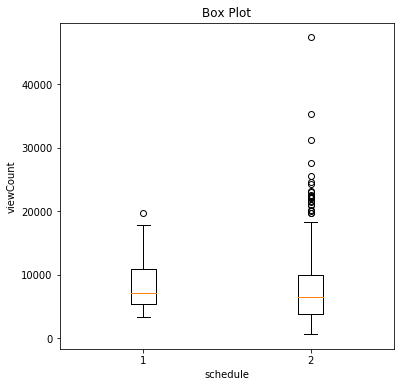

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 6))
plt.grid()
plt.boxplot([schedule, non_schedule])
plt.xlabel('schedule')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# Results
일정 영상의 조회수 평균은 8,540회  
일정 아닌 영상의 조회수 평균은 7,555회로 약 1,000회 차이난다.  
(p=0.272)  

# Conclusion
통계적 유의미성을 확보하지 못했으나 밑져야 본전이다. 일정 영상 업로드 비율을 높인다.